## Enviorment Setup

In [ ]:
import numpy as np

class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos and self.is_wumpus_alive:
            reward = -1000
            done = True
        else:
            self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self, direction):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        if direction == 0 and self.agent_pos[0] > self.wumpus_pos[0]:  # Shoot up
            self.is_wumpus_alive = False
            return 50
        elif direction == 1 and self.agent_pos[0] < self.wumpus_pos[0]:  # Shoot down
            self.is_wumpus_alive = False
            return 50
        elif direction == 2 and self.agent_pos[1] > self.wumpus_pos[1]:  # Shoot left
            self.is_wumpus_alive = False
            return 50
        elif direction == 3 and self.agent_pos[1] < self.wumpus_pos[1]:  # Shoot right
            self.is_wumpus_alive = False
            return 50

        return -1

## Q-learning

In [ ]:
class QLearningAgent:
    def __init__(self, env):
        self.env = env
        self.q_table = np.zeros((env.size, env.size, 4))
        self.learning_rate = 0.1
        self.discount_factor = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def choose_action(self, state):
        agent_pos = np.unravel_index(state.argmax(), (self.env.size, self.env.size))
        if np.random.rand() < self.epsilon:
            return np.random.choice(4)
        return np.argmax(self.q_table[agent_pos])

    def learn(self, state, action, reward, next_state, done):
        agent_pos = np.unravel_index(state.argmax(), (self.env.size, self.env.size))
        next_agent_pos = np.unravel_index(next_state.argmax(), (self.env.size, self.env.size))
        current_q = self.q_table[agent_pos[0], agent_pos[1], action]
        max_next_q = np.max(self.q_table[next_agent_pos[0], next_agent_pos[1]])
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * max_next_q)
        self.q_table[agent_pos[0], agent_pos[1], action] = new_q
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


## Deep Q-Learning

In [ ]:
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

# Setting up device for GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 4
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = DQN(self.state_size, self.action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.model(state)
        return np.argmax(q_values.cpu().data.numpy())

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            reward = torch.FloatTensor([reward]).to(device)
            done = torch.FloatTensor([done]).to(device)

            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).detach()
            target_f = self.model(state)
            target_f[action] = target

            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## Training and Evaluation

Episode 1/1000, Reward: -1013
Episode 2/1000, Reward: -1016
Episode 3/1000, Reward: -1001
Episode 4/1000, Reward: -1023
Episode 5/1000, Reward: -1011
Episode 6/1000, Reward: -1004
Episode 7/1000, Reward: -1027
Episode 8/1000, Reward: -1001
Episode 9/1000, Reward: -1014
Episode 10/1000, Reward: -1001
Episode 11/1000, Reward: -1007
Episode 12/1000, Reward: -1009
Episode 13/1000, Reward: -1001
Episode 14/1000, Reward: -1002
Episode 15/1000, Reward: -1007
Episode 16/1000, Reward: -1004
Episode 17/1000, Reward: -1015
Episode 18/1000, Reward: -1004
Episode 19/1000, Reward: -1003
Episode 20/1000, Reward: -1008
Episode 21/1000, Reward: -1008
Episode 22/1000, Reward: -1004
Episode 23/1000, Reward: -1002
Episode 24/1000, Reward: -1011
Episode 25/1000, Reward: -1004
Episode 26/1000, Reward: -1007
Episode 27/1000, Reward: -1004
Episode 28/1000, Reward: -1001
Episode 29/1000, Reward: -1015
Episode 30/1000, Reward: -1004
Episode 31/1000, Reward: -1007
Episode 32/1000, Reward: -1005
Episode 33/1000, 

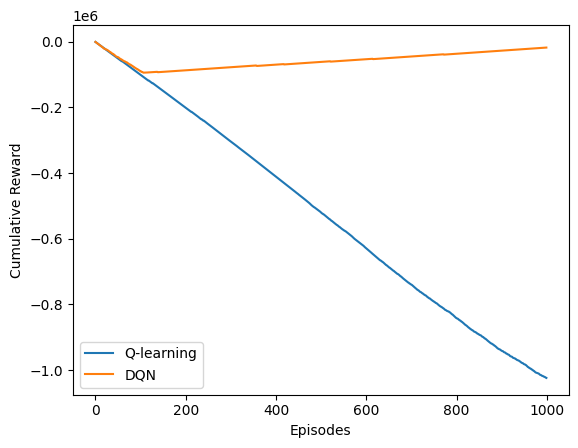

Average Reward per Episode - Q-learning: -1023.903
Average Reward per Episode - DQN: -18.224


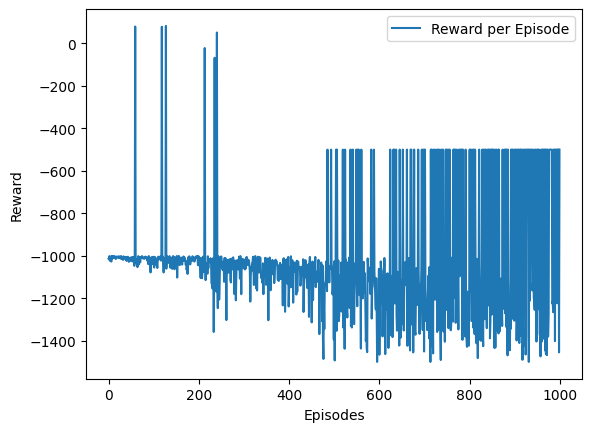

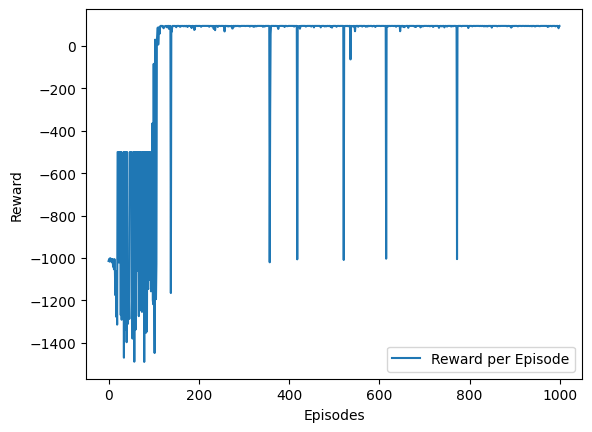

In [ ]:
import matplotlib.pyplot as plt

def train_agent(agent, episodes):
    rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(500):
            action = agent.choose_action(state) if isinstance(agent, QLearningAgent) else agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            if isinstance(agent, QLearningAgent):
                agent.learn(state, action, reward, next_state, done)
            else:
                agent.remember(state, action, reward, next_state, done)
                if len(agent.memory) > 32:
                    agent.replay(32)
            state = next_state
            if done:
                break
        rewards.append(total_reward)
        print(f"Episode {e + 1}/{episodes}, Reward: {total_reward}")
    return rewards

# Initialize environment and agents
env = WumpusWorld()
q_agent = QLearningAgent(env)
dqn_agent = DQNAgent(env)

# Train agents
q_learning_rewards = train_agent(q_agent, 1000)
dqn_rewards = train_agent(dqn_agent, 1000)

# Plot cumulative rewards
plt.plot(np.cumsum(q_learning_rewards), label='Q-learning')
plt.plot(np.cumsum(dqn_rewards), label='DQN')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

# Average reward per episode
q_avg_reward = np.mean(q_learning_rewards)
dqn_avg_reward = np.mean(dqn_rewards)
print(f"Average Reward per Episode - Q-learning: {q_avg_reward}")
print(f"Average Reward per Episode - DQN: {dqn_avg_reward}")

# Analysis
def analyze_performance(rewards):
    episodes = np.arange(len(rewards))
    plt.plot(episodes, rewards, label='Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

analyze_performance(q_learning_rewards)
analyze_performance(dqn_rewards)


## Performance for Q-learning Agent

In [ ]:
def train_q_agent_and_check_consistency(agent, episodes, consistency_threshold=10):
    rewards = []
    consistent_episodes = 0
    consistent_reward_threshold = 0
    consistent_found = False
    consistent_episode = 0

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(500):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        rewards.append(total_reward)
        if total_reward >= consistent_reward_threshold:
            consistent_episodes += 1
        else:
            consistent_episodes = 0

        if consistent_episodes >= consistency_threshold:
            consistent_found = True
            consistent_episode = e + 1 - consistency_threshold
            break

        print(f"Episode {e + 1}/{episodes}, Reward: {total_reward}")

    return rewards, consistent_found, consistent_episode

# Initialize environment and agent
env = WumpusWorld()
q_agent = QLearningAgent(env)

# Train agent and check for consistency
q_learning_rewards, q_consistent_found, q_consistent_episode = train_q_agent_and_check_consistency(q_agent, 1000)

print(f"Q-learning agent found consistent policy: {q_consistent_found} after {q_consistent_episode} episodes")


Episode 1/1000, Reward: -1010
Episode 2/1000, Reward: -1001
Episode 3/1000, Reward: -1003
Episode 4/1000, Reward: -1001
Episode 5/1000, Reward: -1022
Episode 6/1000, Reward: -1003
Episode 7/1000, Reward: -1001
Episode 8/1000, Reward: -1001
Episode 9/1000, Reward: -1015
Episode 10/1000, Reward: -1009
Episode 11/1000, Reward: -1003
Episode 12/1000, Reward: -1001
Episode 13/1000, Reward: -1006
Episode 14/1000, Reward: -1004
Episode 15/1000, Reward: -1003
Episode 16/1000, Reward: 84
Episode 17/1000, Reward: -1020
Episode 18/1000, Reward: -1014
Episode 19/1000, Reward: -1008
Episode 20/1000, Reward: -1011
Episode 21/1000, Reward: -1020
Episode 22/1000, Reward: -1004
Episode 23/1000, Reward: -1003
Episode 24/1000, Reward: -1010
Episode 25/1000, Reward: -1002
Episode 26/1000, Reward: -1021
Episode 27/1000, Reward: 85
Episode 28/1000, Reward: -1001
Episode 29/1000, Reward: -1001
Episode 30/1000, Reward: -1003
Episode 31/1000, Reward: -1001
Episode 32/1000, Reward: -1005
Episode 33/1000, Reward

## Performance for DQN Agent

In [ ]:
def train_dqn_agent_and_check_consistency(agent, episodes, consistency_threshold=10):
    rewards = []
    consistent_episodes = 0
    consistent_reward_threshold = 0
    consistent_found = False
    consistent_episode = 0

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            if len(agent.memory) > 32:
                agent.replay(32)
            state = next_state
            if done:
                break
        rewards.append(total_reward)
        if total_reward >= consistent_reward_threshold:
            consistent_episodes += 1
        else:
            consistent_episodes = 0

        if consistent_episodes >= consistency_threshold:
            consistent_found = True
            consistent_episode = e + 1 - consistency_threshold
            break

        print(f"Episode {e + 1}/{episodes}, Reward: {total_reward}")

    return rewards, consistent_found, consistent_episode

# Initialize environment and agent
dqn_agent = DQNAgent(env)

# Train agent and check for consistency
dqn_rewards, dqn_consistent_found, dqn_consistent_episode = train_dqn_agent_and_check_consistency(dqn_agent, 1000)

print(f"DQN agent found consistent policy: {dqn_consistent_found} after {dqn_consistent_episode} episodes")


Episode 1/1000, Reward: -1004
Episode 2/1000, Reward: -1011
Episode 3/1000, Reward: -1001
Episode 4/1000, Reward: -1004
Episode 5/1000, Reward: -1026
Episode 6/1000, Reward: -1002
Episode 7/1000, Reward: -1013
Episode 8/1000, Reward: -1013
Episode 9/1000, Reward: -1004
Episode 10/1000, Reward: -1005
Episode 11/1000, Reward: -1002
Episode 12/1000, Reward: -1086
Episode 13/1000, Reward: -1081
Episode 14/1000, Reward: -1120
Episode 15/1000, Reward: -1033
Episode 16/1000, Reward: -64
Episode 17/1000, Reward: -1181
Episode 18/1000, Reward: -342
Episode 19/1000, Reward: -1390
Episode 20/1000, Reward: -1007
Episode 21/1000, Reward: -344
Episode 22/1000, Reward: 6
Episode 23/1000, Reward: -100
Episode 24/1000, Reward: -1038
Episode 25/1000, Reward: -1254
Episode 26/1000, Reward: -206
Episode 27/1000, Reward: -500
Episode 28/1000, Reward: 85
Episode 29/1000, Reward: -30
Episode 30/1000, Reward: 95
Episode 31/1000, Reward: 63
Episode 32/1000, Reward: 95
Episode 33/1000, Reward: 95
Episode 34/100

Comparison of Optimal Policy Time


In [ ]:
if q_consistent_found and dqn_consistent_found:
    print(f"Q-learning agent found the optimal policy in {q_consistent_episode} episodes")
    print(f"DQN agent found the optimal policy in {dqn_consistent_episode} episodes")
    if q_consistent_episode < dqn_consistent_episode:
        print("Q-learning agent learned the optimal policy faster.")
    else:
        print("DQN agent learned the optimal policy faster.")
elif q_consistent_found:
    print(f"Only Q-learning agent found the optimal policy in {q_consistent_episode} episodes")
elif dqn_consistent_found:
    print(f"Only DQN agent found the optimal policy in {dqn_consistent_episode} episodes")
else:
    print("Neither agent found a consistent optimal policy within the given episodes.")


Only DQN agent found the optimal policy in 29 episodes
